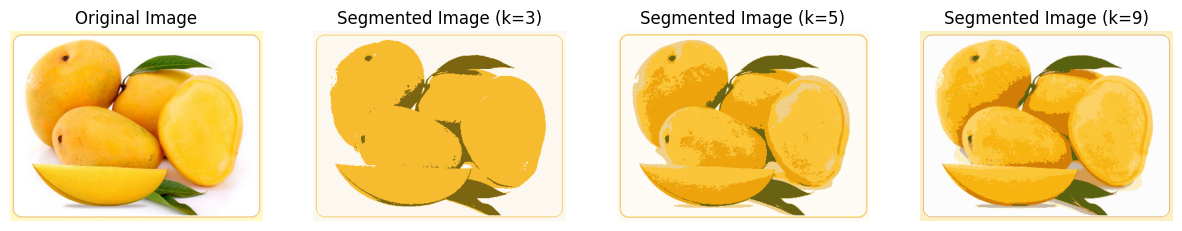

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

def assign_clusters(pixels, centroids):
    labels = []
    for pixel in pixels:
        distances = [euclidean_distance(pixel, centroid) for centroid in centroids]
        label = np.argmin(distances)
        labels.append(label)
    return np.array(labels)

def update_centroids(pixels, labels, k):
    new_centroids = np.zeros((k, 3))
    for i in range(k):
        cluster_pixels = pixels[labels == i]
        if len(cluster_pixels) > 0:
            new_centroids[i] = np.mean(cluster_pixels, axis=0)
    return new_centroids

def kmeans(pixels, k, max_iters=100):
    initial_centroids = pixels[np.random.choice(pixels.shape[0], k, replace=False)]
    centroids = initial_centroids
    for _ in range(max_iters):
        labels = assign_clusters(pixels, centroids)
        new_centroids = update_centroids(pixels, labels, k)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return labels, centroids

# Load the image
rgb = Image.open('Downloads/totapuri_1.jpg')
image_rgb = np.array(rgb)

pixels = image_rgb.reshape((-1, 3))

k_values = [3, 5, 9]
segmented_images = []

for k in k_values:
    labels, centroids = kmeans(pixels, k)
    segmented_image = np.zeros_like(pixels)
    for i in range(k):
        segmented_image[labels == i] = centroids[i]
    segmented_image = segmented_image.reshape(image_rgb.shape)
    segmented_images.append(segmented_image)


plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(image_rgb)
plt.axis('off')

for i, k in enumerate(k_values, start=2):
    plt.subplot(1, 4, i)
    plt.title(f"Segmented Image (k={k})")
    plt.imshow(segmented_images[i-2])
    plt.axis('off')

plt.show()



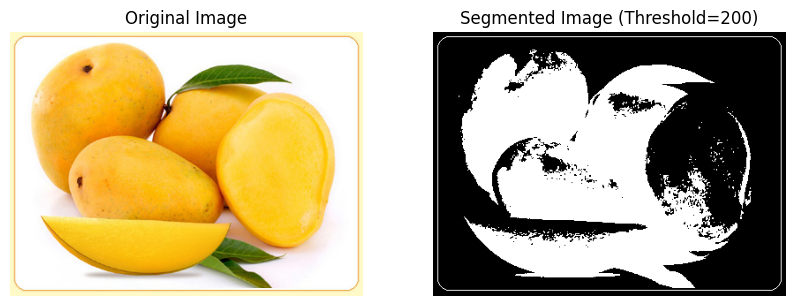

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


rgb = Image.open("Downloads/totapuri_1.jpg") 
rgb = np.array(rgb)  

def manual_thresholding(image, threshold):
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Use COLOR_RGB2GRAY if image is from PIL
    else:
        gray_image = image

    segmented_image = np.zeros_like(gray_image)
    
    for i in range(gray_image.shape[0]):
        for j in range(gray_image.shape[1]):
            if gray_image[i, j] >= threshold:
                segmented_image[i, j] = 0
            else:
                segmented_image[i, j] = 255
    
    return segmented_image

threshold_value = 200
segmented_image = manual_thresholding(rgb, threshold_value)
-
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title(f"Segmented Image (Threshold={threshold_value})")
plt.axis('off')

plt.show()


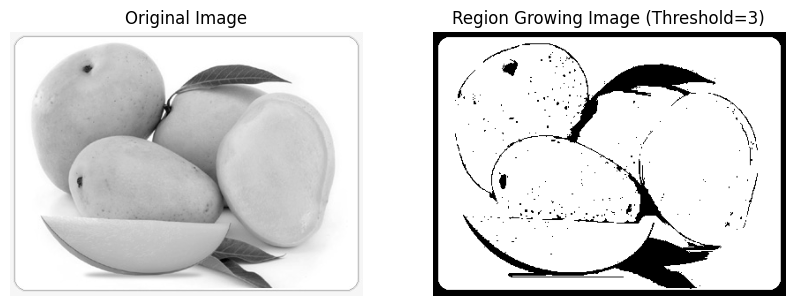

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_growing(image, seed, threshold):
    gray_image = image
    segmented_image = np.zeros_like(gray_image)
    to_process = [seed]
    neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    segmented_image[seed] = 255
    
    while to_process:
        current_pixel = to_process.pop(0)
        current_x, current_y = current_pixel
        current_value = gray_image[current_x, current_y]
        
        for dx, dy in neighbors:
            nx, ny = current_x + dx, current_y + dy
            
            if 0 <= nx < gray_image.shape[0] and 0 <= ny < gray_image.shape[1]:
                if segmented_image[nx, ny] == 0:
                    if abs(int(gray_image[nx, ny]) - int(current_value)) <= threshold:
                        segmented_image[nx, ny] = 255
                        to_process.append((nx, ny))
    
    return segmented_image

image = cv2.imread('Downloads/totapuri_1.jpg', cv2.IMREAD_GRAYSCALE)
seed_pixel = (100, 100)
threshold_value = 3
segmented_image = region_growing(image, seed_pixel, threshold_value)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.title(f"Region Growing Image (Threshold={threshold_value})")
plt.axis('off')

plt.show()


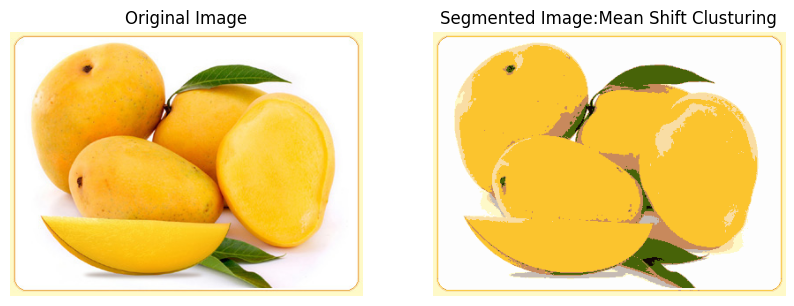

In [5]:
from sklearn.cluster import MeanShift, estimate_bandwidth
pixels = rgb.reshape((-1, 3))
bandwidth = estimate_bandwidth(pixels, quantile=0.1, n_samples=500)
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
mean_shift.fit(pixels)

labels = mean_shift.labels_
cluster_centers = mean_shift.cluster_centers_

segmented_image = cluster_centers[labels].reshape(rgb.shape)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image.astype(np.uint8))
plt.title('Segmented Image:Mean Shift Clusturing')
plt.axis('off')

plt.show()



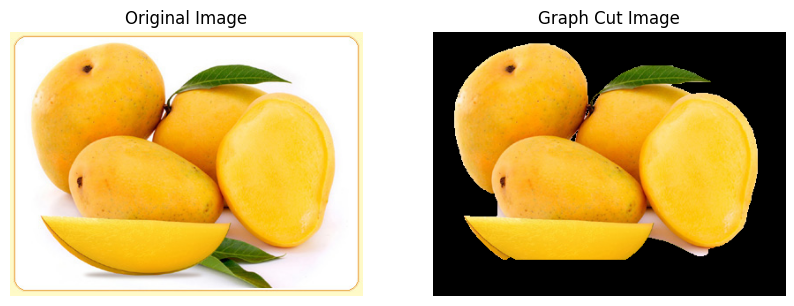

In [6]:
mask = np.zeros(rgb.shape[:2], np.uint8)
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)
rect = (20,9, rgb.shape[1] - 50, rgb.shape[0] - 50)

cv2.grabCut(rgb, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1)
segmented_image = rgb * mask2[:, :, np.newaxis]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title('Graph Cut Image')
plt.axis('off')

plt.show()
